In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

data = pd.read_csv('heart.csv')

# One hot encoding categorical data with >2 classes
one_hot_cols = ['ChestPainType', 'RestingECG', 'ST_Slope']
oh_encoder = OneHotEncoder()

# Using OrdinalEncoder to encoder categorical data with 2 classes into binary
binary_cols = ['Sex', 'ExerciseAngina']
binary_encoder = OrdinalEncoder()

preprocessing = ColumnTransformer(
    [
        ('one_hot', oh_encoder, one_hot_cols),
        ('binary', binary_encoder, binary_cols),
    ],
    remainder = 'passthrough'
)

X = data.drop(columns='HeartDisease')
y = data['HeartDisease']

Cross Validation Accuracy:
0.8300653594771242
Confusion Matrix:


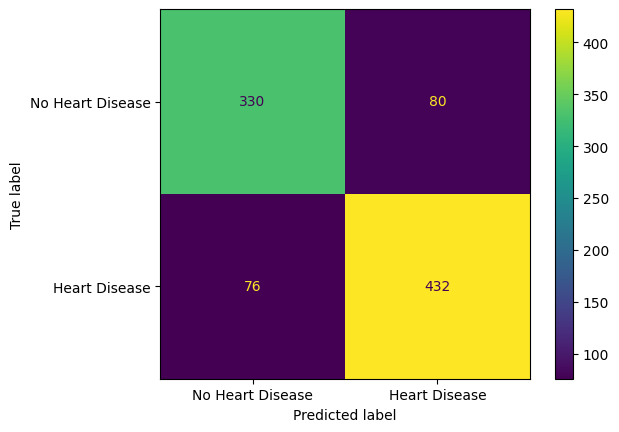

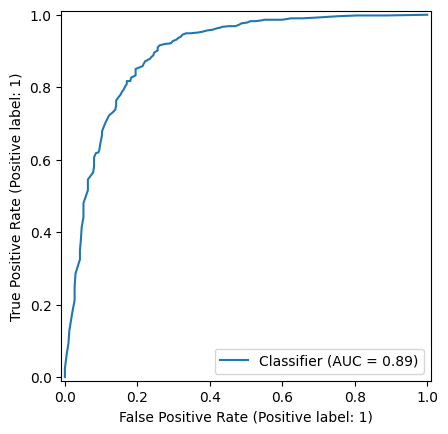

In [2]:
# Before parameter tuning
rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=0)),
    ]
)

y_pred = cross_val_predict(rf, X, y, cv=5)

print('Cross Validation Accuracy:')
print(accuracy_score(y, y_pred))

# print("Classification Report:")
# print(classification_report(y, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['No Heart Disease', 'Heart Disease'])
disp.plot()

# Get ROC curve
y_pred_probs = cross_val_predict(rf, X, y, cv=5, method='predict_proba')[:, 1]
RocCurveDisplay.from_predictions(y, y_pred_probs)
plt.show()

1
5
10
25
50
100
200
500
[0.7562687099073415, 0.800575354399303, 0.8074158549140731, 0.8247529104300309, 0.825120376969985, 0.8297731052506533, 0.8308663974023917, 0.8319493941553813]


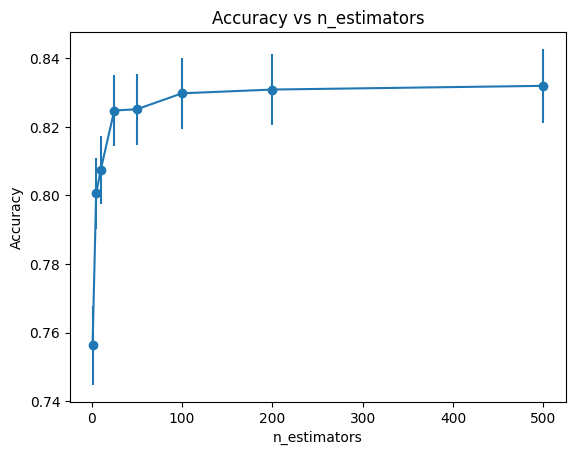

In [3]:
# Cross validation for tuning n_estimators (number of trees)
n_params = [1, 5, 10, 25, 50, 100, 200, 500]
state_means = []
error = []
for n in n_params:
    print(n)
    all_scores = []
    for i in range(15):
        rf = Pipeline(
            [
                ("preprocess", preprocessing),
                ("classifier", RandomForestClassifier(n_estimators = n, random_state=i)),
            ]
        )
        cv_scores = cross_val_score(rf, X, y, cv = 5, scoring = 'accuracy')
        all_scores.extend(cv_scores)
    state_means.append(np.mean(all_scores))
    error.append(np.mean(all_scores) - st.t.interval(0.95, len(all_scores)-1, loc=np.mean(all_scores), scale=st.sem(all_scores))[0])
plt.errorbar(n_params, state_means, error, fmt='-o')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs n_estimators')
print(state_means)

# Found that generally n_estimators of 100 and up were the best, with improvements falling off a lot after that point.
# Went with 100, mostly to save on compute time over the higher options

1
2
4
8
13
18
[0.8386520947176686, 0.8396598558644176, 0.8297731052506533, 0.8215700483091788, 0.816416013304823, 0.8093601013700802]


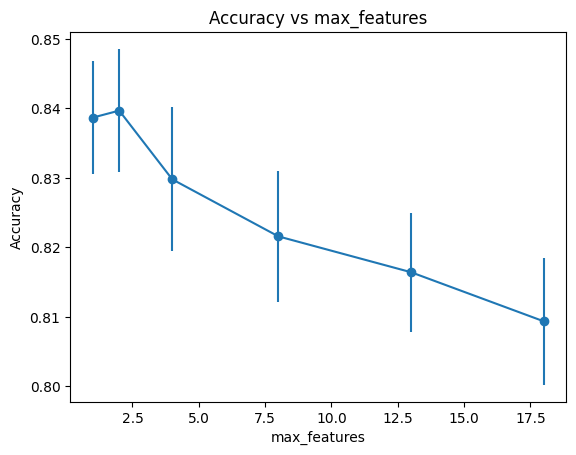

In [4]:
# Cross validation for tuning max_features
n_params = [1, 2, 4, 8, 13, 18]
state_means = []
error = []
for n in n_params:
    print(n)
    all_scores = []
    for i in range(15):
        rf = Pipeline(
            [
                ("preprocess", preprocessing),
                ("classifier", RandomForestClassifier(max_features = n, random_state=i)),
            ]
        )
        cv_scores = cross_val_score(rf, X, y, cv = 5, scoring = 'accuracy')
        all_scores.extend(cv_scores)
    state_means.append(np.mean(all_scores))
    error.append(np.mean(all_scores) - st.t.interval(0.95, len(all_scores)-1, loc=np.mean(all_scores), scale=st.sem(all_scores))[0])
plt.errorbar(n_params, state_means, error, fmt='-o')
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs max_features')
print(state_means)

# Found that lower values 1-2 tend to be better, with a definite fall off at 13 and up. Went with 2

2
3
5
8
10
[0.8396598558644176, 0.8383376890789578, 0.8365945988754256, 0.8380403104458699, 0.8355009107468124]


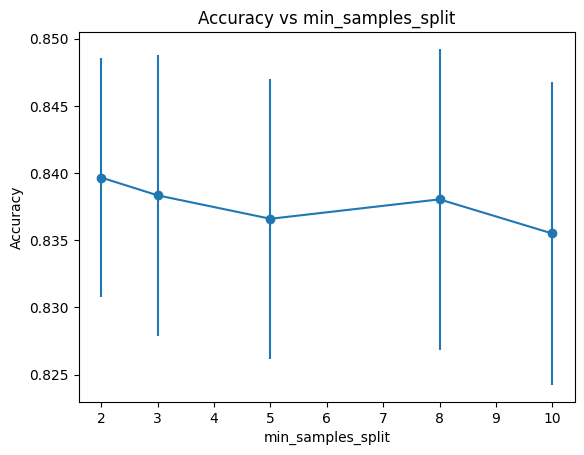

In [5]:
# Cross validation for tuning min_samples_split
n_params = [2, 3, 5, 8, 10]
state_means = []
error = []
for n in n_params:
    print(n)
    all_scores = []
    for i in range(15):
        rf = Pipeline(
            [
                ("preprocess", preprocessing),
                ("classifier", RandomForestClassifier(max_features = 2, min_samples_split = n, random_state=i)),
            ]
        )
        cv_scores = cross_val_score(rf, X, y, cv = 5, scoring = 'accuracy')
        all_scores.extend(cv_scores)
    state_means.append(np.mean(all_scores))
    error.append(np.mean(all_scores) - st.t.interval(0.95, len(all_scores)-1, loc=np.mean(all_scores), scale=st.sem(all_scores))[0])
plt.errorbar(n_params, state_means, error, fmt='-o')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Accuracy vs min_samples_split')
print(state_means)

# Found lower values tended to be better, though lots of variance and nothing conclusive. Default of 2 was chosen

1
3
5
10
20
40
[0.8396598558644176, 0.8399901005781263, 0.84108062089174, 0.8424574324859428, 0.8423746733190782, 0.8398340856893958]


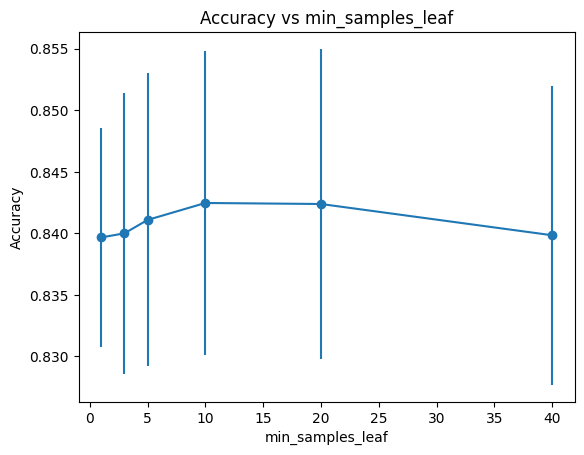

In [6]:
# Cross validation for tuning min_samples_leaf
n_params = [1, 3, 5, 10, 20, 40]
state_means = []
error = []
for n in n_params:
    print(n)
    all_scores = []
    for i in range(15):
        rf = Pipeline(
            [
                ("preprocess", preprocessing),
                ("classifier", RandomForestClassifier(max_features = 2, min_samples_leaf = n, random_state=i)),
            ]
        )
        cv_scores = cross_val_score(rf, X, y, cv = 5, scoring = 'accuracy')
        all_scores.extend(cv_scores)
    state_means.append(np.mean(all_scores))
    error.append(np.mean(all_scores) - st.t.interval(0.95, len(all_scores)-1, loc=np.mean(all_scores), scale=st.sem(all_scores))[0])
plt.errorbar(n_params, state_means, error, fmt='-o')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Accuracy vs min_samples_leaf')
print(state_means)

# Found that 10-20 was optimal, though not conclusive.
# Went with 10.

Cross Validation Accuracy:
0.840958605664488
Confusion Matrix:


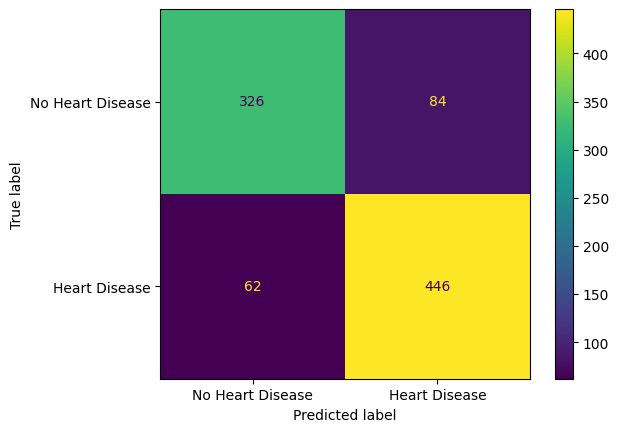

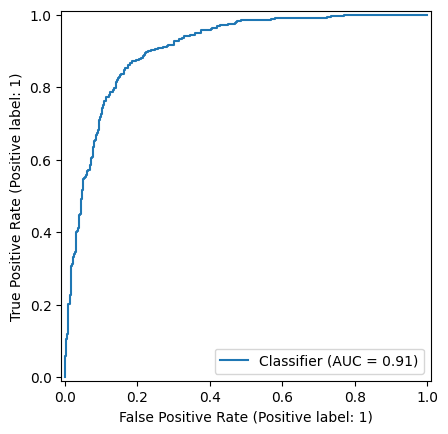

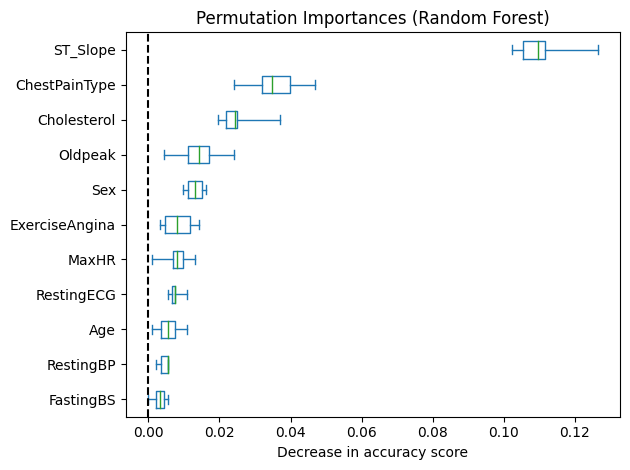

In [7]:
# Final Model. Mean 5-fold cross validation accuracy of ~84%.
rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(max_features = 2, min_samples_leaf = 10, random_state=0)),
    ]
)

y_pred = cross_val_predict(rf, X, y, cv=5)

print('Cross Validation Accuracy:')
print(accuracy_score(y, y_pred))

# print("Classification Report:")
# print(classification_report(y, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['No Heart Disease', 'Heart Disease'])
disp.plot()

# Get ROC curve
y_pred_probs = cross_val_predict(rf, X, y, cv=5, method='predict_proba')[:, 1]
RocCurveDisplay.from_predictions(y, y_pred_probs)
plt.show()


rf.fit(X, y)
result = permutation_importance(rf, X, y, n_repeats=10, random_state=0, n_jobs=-1)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (Random Forest)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
plt.tight_layout()
plt.rcParams.update({'font.size': 10})
plt.show()